**Table of contents**<a id='toc0_'></a>    
- 1. [Load data       ](#toc1_)    
  - 1.1. [Load tremor catalog     ](#toc1_1_)    
  - 1.2. [Load earthquake catalog (JMA)       ](#toc1_2_)    
  - 1.3. [Get tremor depth by projecting onto slab    ](#toc1_3_)    
- 2. [Project tremor along strike   ](#toc2_)    
- 3. [Trim catalogs   ](#toc3_)    
- 4. [Measure earthquake tremor distance  ](#toc4_)    
- 5. [Count earthquakes "felt" by tremor       ](#toc5_)    
- 6. [Inspect results ](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [3]:
# Imports
%matplotlib widget 
import numpy as np
import pandas as pd

from scipy.spatial import cKDTree

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import os
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    workdir = '/Users/gaspard/Documents/work/'

# 1. <a id='toc1_'></a>Load data        [&#128285;](#toc0_)

## 1.1. <a id='toc1_1_'></a>Load LFE catalog      [&#128285;](#toc0_)

In [4]:
# Load LFE catalog
path = "~/Documents/work/projects/data/Catalogs/nankai_lfe_kato20_04_15/Kato2020-LFE.csv"
lfe = pd.read_csv(path)
lfe.rename(columns={"min": "minute", "sec": "second", "dep":"depth"}, inplace=True)
lfe["date"] = pd.to_datetime(lfe[["year", "month", "day", "hour", "minute", "second"]])

lfe.drop(columns=["year", "month", "day", "hour", "minute", "second", "timezone", "time", "catalog", "ref", "udate"], inplace=True)

lfe["day"] = (lfe.date - lfe.date.min()) / np.timedelta64(1, 'D')

# sort by days
lfe.sort_values("day", inplace=True)

In [5]:
# Make LFE families
unique_locations = np.unique(lfe[["lon", "lat", "depth"]], axis=0)

n_ev_fam = np.zeros(unique_locations.shape[0], dtype=int)
for ifam in range(unique_locations.shape[0]):
    # Number families
    ev_in_fam = (lfe.lon == unique_locations[ifam, 0]) & (lfe.lat == unique_locations[ifam, 1]) & (lfe.depth == unique_locations[ifam, 2])
    lfe.loc[ev_in_fam, "family"] = ifam

    # Count number of events in said family
    n_ev_fam[ifam] = np.sum(ev_in_fam)

# Make dataframe of families (ifam, lon, lat, depth, n_ev)
lfe_fam = pd.DataFrame(data={"id": np.arange(unique_locations.shape[0]), "lon": unique_locations[:, 0], "lat": unique_locations[:, 1], "depth": unique_locations[:, 2], "n_ev": n_ev_fam})

## 1.2. <a id='toc1_2_'></a>Load earthquake catalog (JMA)        [&#128285;](#toc0_)

In [6]:
# Directly load catalog from csv
eq = pd.read_csv(workdir + 'projects/data/Catalogs/JMA/jma_1951_2023.csv')
eq['date'] = pd.to_datetime(eq['date'])
eq.rename(columns={'longitude': 'lon', 'latitude': 'lat'}, inplace=True)

# Filter catalog
eq = eq[eq['evtype'] == 1]  # keep only earthquakes
eq = eq[eq['mag'] >= 1]  # keep only earthquakes with magnitude >= 1
eq = eq[eq['date'] >= '2000-01-01']  # keep only earthquakes after 2000 (shorter computation time)

lon_min = 130
lon_max = 140
lat_min = 31
lat_max = 37

indicator = (eq.lon > lon_min) & (eq.lon < lon_max) & (eq.lat > lat_min) & (eq.lat < lat_max)
eq = eq[indicator].copy()
print('{:d} events in the selected region'.format(len(eq)))

493553 events in the selected region


# 2. <a id='toc2_'></a>Project along strike    [&#128285;](#toc0_)

In [7]:
# Define strike
# --> Get cartesian coordinates for everyone
crs = ccrs.TransverseMercator(central_longitude=lfe.lon.mean(), central_latitude=lfe.lat.mean())

lfe_coords = crs.transform_points(ccrs.PlateCarree(), lfe.lon.values, lfe.lat.values)
lfe_fam_coords = crs.transform_points(ccrs.PlateCarree(), lfe_fam.lon.values, lfe_fam.lat.values)
eq_coords = crs.transform_points(ccrs.PlateCarree(), eq.lon.values, eq.lat.values)

lfe.loc[:, 'x'] = lfe_coords[:, 0]/1000  # x is easting (km)
lfe.loc[:, 'y'] = lfe_coords[:, 1]/1000  # y is northing (km)
lfe_fam.loc[:, 'x'] = lfe_fam_coords[:, 0]/1000  # x is easting (km)
lfe_fam.loc[:, 'y'] = lfe_fam_coords[:, 1]/1000  # y is northing (km)
eq.loc[:, 'x'] = eq_coords[:, 0]/1000
eq.loc[:, 'y'] = eq_coords[:, 1]/1000

# Define along-strike: fit a polynomial to the LFE line, loaded from the main LFE catalog
import pickle
along_strike = pickle.load(open('data/nankai/processed/nankai_along_strike.pkl', 'rb'))
X = along_strike['x']
Y = along_strike['y']
S = along_strike['s']

# --> "Project" LFEs along strike
tree = cKDTree(np.column_stack((X, Y)))
lfe_across_strike_dist, lfe_nearest_idx = tree.query(np.column_stack((lfe.x, lfe.y)))

lfe_along_strike_dist = S[lfe_nearest_idx]

lfe['xf'] = lfe_along_strike_dist
lfe['yf'] = lfe_across_strike_dist

# --> Project LFE families along-strike
lfe_fam_across_strike_dist, lfe_fam_nearest_idx = tree.query(np.column_stack((lfe_fam.x, lfe_fam.y)))
lfe_fam_along_strike_dist = S[lfe_fam_nearest_idx]

lfe_fam['xf'] = lfe_fam_along_strike_dist
lfe_fam['yf'] = lfe_fam_across_strike_dist

# --> Project earthquakes along-strike: nearest point from each event to the strike line (~1min for 1.7M events)
eq_across_strike_dist, eq_nearest_idx = tree.query(np.column_stack((eq.x, eq.y)))
eq_along_strike_dist = S[eq_nearest_idx]

eq['xf'] = eq_along_strike_dist # xf or xfault: along-strike distance in km
eq['yf'] = eq_across_strike_dist  # yf or yfault: across-strike distance in km

# # Show
# fig, axes = plt.subplots(2, 1, figsize=(10, 10))
# for ax in axes:
#     ax.set_aspect('equal')
#     ax.set_xlabel('x (km)')  
#     ax.set_ylabel('y (km)')
#     ax.plot(X, Y, 'r', zorder=10)

# # axes[0].scatter(eq.x, eq.y, s=eq.mag**3, c=eq_along_strike_dist, ec='k', cmap='viridis', vmin=0, vmax=1500)
# axes[0].scatter(lfe.x, lfe.y, s=1, c=lfe_along_strike_dist, cmap='viridis', vmin=0, vmax=1000)

# # axes[1].scatter(eq.x, eq.y, s=eq.mag**3, c=eq_across_strike_dist, ec='k', cmap='viridis')
# axes[1].scatter(lfe.x, lfe.y, s=1, c=lfe_across_strike_dist, cmap='viridis', vmax=50)

# plt.tight_layout()
# plt.show()


# 3. <a id='toc3_'></a>Trim catalogs    [&#128285;](#toc0_)

In [8]:
# Trim earthquakes and LFEs to same time period
print('LFEs', lfe.date.min(), lfe.date.max())
print('Earthquakes', eq.date.min(), eq.date.max())

interval = [np.datetime64('2004-04-01'), np.datetime64('2015-09-01')]
eq = eq[(eq.date.values > interval[0]) & (eq.date.values < interval[1])]
lfe = lfe[(lfe.date.values > interval[0]) & (lfe.date.values < interval[1])]

print('\nChosen interval', interval)

LFEs 2004-04-01 00:42:28.740000 2015-08-31 21:02:07.810000
Earthquakes 2000-01-01 03:50:13.020000 2023-03-31 23:39:27.180000

Chosen interval [numpy.datetime64('2004-04-01'), numpy.datetime64('2015-09-01')]


# 4. <a id='toc4_'></a>Measure earthquake LFE distance   [&#128285;](#toc0_)

In [9]:
# Measure distance between earthquakes and the nearest LFE family
tree = cKDTree(np.column_stack((lfe_fam.x.values, lfe_fam.y.values, lfe_fam.depth.values)))

dist2lfe, idx = tree.query(np.column_stack((eq.x, eq.y, eq.depth)))
eq['dist2trm'] = dist2lfe

In [10]:
# Save processed earthquakes (trimmed, distance to tremor computed)
path = 'data/nankai/processed/nank_eq_0404_0915.csv'
print('Saving to ', path)
eq.to_csv(path, index=False)

Saving to  data/nankai/processed/nank_eq_0404_0915.csv


# 5. <a id='toc5_'></a>Count earthquakes "felt" by LFE patches        [&#128285;](#toc0_)

In [11]:
# Which distance and magnitude bins
min_mags = [2.4, 2.2, 2., 1.8, 1.5, 1.]
distances = [10, 20, 30, 50, 100]

In [12]:
# Run through minimum magnitudes and distance, and compute number of earthquakes within distance of LFE (~10 min for the whole run)

for min_mag in min_mags:
    # --> Select earthquakes
    selected_eq = eq[
        (eq.mag >= min_mag) \
        & (eq.dist2trm <= np.max(distances))
    ]
    print('Mmin =', min_mag, 'Neq =', len(selected_eq))

    # --> Make trees
    eq_tree = cKDTree(selected_eq[['x', 'y', 'depth']].values)
    lfe_tree = cKDTree(lfe_fam[['x', 'y', 'depth']].values)
    
    for dist in distances:
        print('d <', dist)
        # Query LFE tree to find which earthquakes are closer than `dist`
        eq_neighbors_idxs = lfe_tree.query_ball_tree(eq_tree, dist)  # a tuple of eq indices for each LFE event

        # Count number of neighbors for each LFE event
        n_eq_neighbors = np.array([len(e) for e in eq_neighbors_idxs])

        # Convert to number of eq neighbors per year analyzed
        n_eq_neighbors = n_eq_neighbors / ((interval[1] - interval[0]).astype('timedelta64[D]').astype(int) / 365)

        # Store information in LFE dataset
        new_key = "m{:.1f}in{:d}km".format(min_mag, dist)
        lfe_fam[new_key] = n_eq_neighbors
        
        # Give each LFE the distance along-strike of its family (takes most time)
        for id in lfe_fam.id.values:
            lfe.loc[lfe.family == id, new_key] = lfe_fam.loc[lfe_fam.id == id, new_key].values[0]

Mmin = 2.4 Neq = 6263
d < 10
d < 20
d < 30
d < 50
d < 100
Mmin = 2.2 Neq = 9209
d < 10
d < 20
d < 30
d < 50
d < 100
Mmin = 2.0 Neq = 13468
d < 10
d < 20
d < 30
d < 50
d < 100
Mmin = 1.8 Neq = 19749
d < 10
d < 20
d < 30
d < 50
d < 100
Mmin = 1.5 Neq = 35275
d < 10
d < 20
d < 30
d < 50
d < 100
Mmin = 1.0 Neq = 93459
d < 10
d < 20
d < 30
d < 50
d < 100


In [13]:
# Save processed LFE dataset
path = 'data/nankai/processed/nank_lfe_0404_0915.csv'
print('Saving at', path)
lfe.to_csv(path, index=False)

path = 'data/nankai/processed/nank_lfe_fam_0404_0915.csv'
lfe_fam.to_csv(path, index=False)

Saving at data/nankai/processed/nank_lfe_0404_0915.csv


# 6. <a id='toc6_'></a>Inspect results  [&#128285;](#toc0_)

In [14]:
# Load processed results
lfe = pd.read_csv('data/nankai/processed/nank_lfe_0404_0915.csv')
lfe_fam = pd.read_csv('data/nankai/processed/nank_lfe_fam_0404_0915.csv')
eq = pd.read_csv('data/nankai/processed/nank_eq_0404_0915.csv')

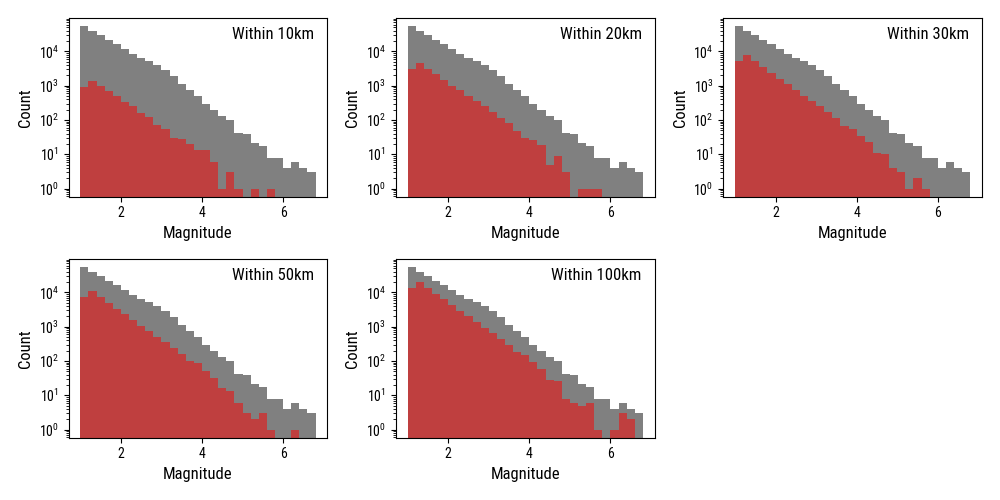

In [15]:
# Magnitude of completeness for each distance

fig, axes = plt.subplots(2, 3, figsize=(10, 5))

for ii in range(6):
    if ii == 5: axes[ii//3, ii%3].remove() ; continue
    ax = axes[ii//3, ii%3]
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Count')
    ax.set_yscale('log')
    ax.text(.95, .95, 'Within {:d}km'.format(distances[ii]), va='top', ha='right', transform=ax.transAxes)

    ax.hist(eq.mag.values, bins=np.arange(1, 7, .2), fc='gray', ec='none')
    ax.hist(eq.mag[(eq.mag > 1) & (eq.dist2trm < distances[ii])].values, bins=np.arange(1, 7, .2), fc=to_rgba('r', .5), ec='none')

plt.tight_layout()
plt.show()

In [16]:
# Which distance/minimum magnitude for maps
min_mag = 2.2

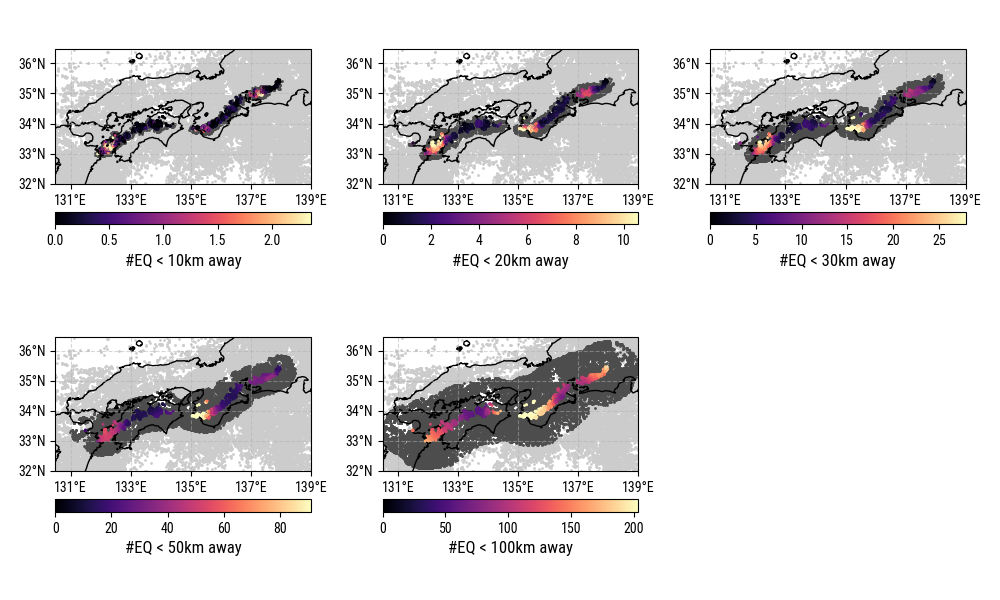

In [17]:
# Maps
lon_min = lfe_fam.lon.min() - 1
lon_max = lfe_fam.lon.max() + 1
lat_min = lfe_fam.lat.min() - 1
lat_max = lfe_fam.lat.max() + 1
crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(10, 6))
axes = [plt.subplot(2, 3, ii+1, projection=crs) for ii in range(5)]

for ii, ax in zip(range(len(distances)), np.array(axes).flatten()):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
    ax.coastlines(lw=1)

    # Plot LFEs
    sc = ax.scatter(lfe_fam.lon, lfe_fam.lat, c=lfe_fam['m{:.1f}in{:d}km'.format(min_mag, distances[ii])], s=1, cmap='magma', transform=crs, vmin=0, vmax=np.percentile(lfe_fam['m{:.1f}in{:d}km'.format(min_mag, distances[ii])], 95), zorder=2, label='LFEs')
    ax.scatter(eq[eq.dist2trm < distances[ii]].lon, eq[eq.dist2trm < distances[ii]].lat, c='.3', s=1, transform=crs, zorder=1, label='Earthquakes in range'.format(distances[ii]))
    ax.scatter(eq.lon, eq.lat, c='.8', s=1, transform=crs, zorder=0, label='All earthquakes')

    # Colorbar
    x_min_ax = 0.5; y_min_ax = -0.2
    w_ax = 0.45; h_ax = 0.05
    x_max_ax = x_min_ax + w_ax; y_max_ax = y_min_ax + h_ax

    cbar = plt.colorbar(sc, orientation='horizontal', label="#EQ < {:d}km away".format(distances[ii]), fraction=0.3, pad=0.1)

    # grid and labels, only bottom and left, not top and right
    ax.set_xticks(np.arange(np.ceil(lon_min), lon_max+1, 2), crs=crs)
    ax.set_yticks(np.arange(np.ceil(lat_min), lat_max, 1), crs=crs)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()